Learnings:
    
- Drop obviously unnecessary columns already in the beginning and drop them explicitly
- Do data type repair and feature extraction
    - First find all potential columns that a specific repair could be applied on
    - Manually select the columns
    - Apply the repair
- Then again look at the columns and remove those that seem unimportant
- Dummies are only useful for training machine learning models. The original value could be needed for other analysis
- Extract new features in the end, after the data set is cleaned

## 1. Business Understanding

Interesting questions could be:
- **Question 1:** Which property type has the highest booking rates?
- **Question 2:** Does the popularity of neighborhoods vary over the year?
- **Question 3:** Predict the booking rate based on the other factors.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

import d6tflow
import luigi
from luigi.util import inherits
import matplotlib.pyplot as plt
import sklearn, sklearn.datasets, sklearn.svm, sklearn.linear_model
#import matplotlib.pyplot as plt

Loading postgres module without psycopg2 installed. Will crash at runtime if postgres functionality is used.
Loading S3 module without the python package boto3. Will crash at runtime if S3 functionality is used.


Welcome to d6tflow!


## 2. Data Understanding

### Gather the data

In [4]:
df_calendar = pd.read_csv('../data/raw/seattle/calendar.csv')
df_listings = pd.read_csv('../data/raw/seattle/listings.csv')
df_reviews = pd.read_csv('../data/raw/seattle/reviews.csv')

### Assess the data

In [5]:
df_reviews.dtypes

listing_id        int64
id                int64
date             object
reviewer_id       int64
reviewer_name    object
comments         object
dtype: object

In [6]:
df_reviews.shape

(84849, 6)

In [7]:
df_calendar.head()

listing_id        date available   price
0      241032  2016-01-04         t  $85.00
1      241032  2016-01-05         t  $85.00
2      241032  2016-01-06         f     NaN
3      241032  2016-01-07         f     NaN
4      241032  2016-01-08         f     NaN

In [8]:
df_calendar.sample(5)

listing_id        date available    price
67545       8097708  2016-01-24         t  $196.00
1036722    10157880  2016-05-05         f      NaN
1191262     1593991  2016-09-27         t  $150.00
183226      1090307  2016-12-30         t  $109.00
1106765     6935953  2016-03-29         t  $200.00

In [9]:
df_calendar.dtypes

listing_id     int64
date          object
available     object
price         object
dtype: object

In [10]:
df_calendar.shape

(1393570, 4)

In [11]:
# collect information about the input_df
def analyze_dataframe(input_df):
    """
    Print out name, sample, dtype, percentage of missing vals, mean/mode and std for each column.
    """
    df = pd.DataFrame()
    for col in input_df.columns:
        d = {}
        # get information for this column
        d['name'] = col
        d['sample'] = input_df[col].sample(1)
        d['dtype'] = input_df[col].dtype
        d['missing'] = input_df[col].isnull().sum() / len(input_df)

        if d['dtype'] in ['float64', 'int64']:
            d['mean/mode'] = input_df[col].mean()
            d['std'] = input_df[col].std()
        else:
            d['mean/mode'] = 'N/A'
            d['std'] = 'N/A'

        df=df.append(pd.DataFrame(data=d), ignore_index=True)
    return df

In [12]:
df = analyze_dataframe(df_listings)
pd.set_option('display.max_rows', None)
df

name  \
0                                 id   
1                        listing_url   
2                          scrape_id   
3                       last_scraped   
4                               name   
5                            summary   
6                              space   
7                        description   
8                experiences_offered   
9              neighborhood_overview   
10                             notes   
11                           transit   
12                     thumbnail_url   
13                        medium_url   
14                       picture_url   
15                    xl_picture_url   
16                           host_id   
17                          host_url   
18                         host_name   
19                        host_since   
20                     host_location   
21                        host_about   
22                host_response_time   
23                host_response_rate   
24              host_acceptance_rate   
25                 host_is_superhost   
26                host_thumbnail_url   
27                  host_picture_url   
28                host_neighbourhood   
29               host_listings_count   
30         host_total_listings_count   
31                host_verifications   
32              host_has_profile_pic   
33            host_identity_verified   
34                            street   
35                     neighbourhood   
36            neighbourhood_cleansed   
37      neighbourhood_group_cleansed   
38                              city   
39                             state   
40                           zipcode   
41                            market   
42                    smart_location   
43                      country_code   
44                           country   
45                          latitude   
46                         longitude   
47                 is_location_exact   
48                     property_type   
49                         room_type   
50                      accommodates   
51                         bathrooms   
52                          bedrooms   
53                              beds   
54                          bed_type   
55                         amenities   
56                       square_feet   
57                             price   
58                      weekly_price   
59                     monthly_price   
60                  security_deposit   
61                      cleaning_fee   
62                   guests_included   
63                      extra_people   
64                    minimum_nights   
65                    maximum_nights   
66                  calendar_updated   
67                  has_availability   
68                   availability_30   
69                   availability_60   
70                   availability_90   
71                  availability_365   
72             calendar_last_scraped   
73                 number_of_reviews   
74                      first_review   
75                       last_review   
76              review_scores_rating   
77            review_scores_accuracy   
78         review_scores_cleanliness   
79             review_scores_checkin   
80       review_scores_communication   
81            review_scores_location   
82               review_scores_value   
83                  requires_license   
84                           license   
85                jurisdiction_names   
86                  instant_bookable   
87               cancellation_policy   
88     require_guest_profile_picture   
89  require_guest_phone_verification   
90    calculated_host_listings_count   
91                 reviews_per_month   

                                               sample    dtype   missing  \
0                                             5262750    int64  0.000000   
1                https://www.airbnb.com/rooms/7093986   object  0.000000   
2                                      20160104002432    int64  0.000000   
3      

In [13]:
cleaned = df_listings

## Drop IDs and URLs and redundant columns

Identify columns that should be dropped by scanning visually and using the background knowledge on the business domain.

In [14]:
# All URLs
cleaned = cleaned.drop(columns=['thumbnail_url',
                                'medium_url',
                                'picture_url',
                                'xl_picture_url',
                                'host_url',
                                'host_thumbnail_url',
                                'host_picture_url',
                                'listing_url'])

# All id$
cleaned = cleaned.drop(columns=['scrape_id',                              
                                'host_id'])

# All the same
cleaned = cleaned.drop(columns=['city',
                                'state',
                                'market',
                                'smart_location',
                                'country_code',
                                'country',
                                'calendar_last_scraped',
                                'license',
                                'jurisdiction_names',
                                'host_listings_count',
                                'square_feet']) # missing in most columns

# Neighborhoods- redundant to neighbourhood_cleansed
cleaned = cleaned.drop(columns=['neighbourhood',
                                'neighbourhood_group_cleansed',
                               'host_location'])

# Uninteresting date-related information
cleaned.drop(columns=['calendar_updated'])

id last_scraped                                  name  \
0       241032   2016-01-04          Stylish Queen Anne Apartment   
1       953595   2016-01-04    Bright & Airy Queen Anne Apartment   
2      3308979   2016-01-04   New Modern House-Amazing water view   
3      7421966   2016-01-04                    Queen Anne Chateau   
4       278830   2016-01-04        Charming craftsman 3 bdm house   
5      5956968   2016-01-04       Private unit in a 1920s mansion   
6      1909058   2016-01-04       Queen Anne Private Bed and Bath   
7       856550   2016-01-04     Tiny Garden cabin on Queen Anne     
8      4948745   2016-01-04      Urban Charm || Downtown || Views   
9      2493658   2016-01-04    Airy + Bright Queen Anne Apartment   
10      175576   2016-01-04   Private Apartment - Queen Anne Hill   
11     4454295   2016-01-04      Upper Queen Anne Craftsman House   
12     3883392   2016-01-04    Open Plan 2bdr/1bath in Queen Anne   
13     8889257   2016-01-04       Elegance in Historic Queen Anne   
14     5680462   2016-01-04   Stunning 6 bd in THE BEST Location!   
15     8988178   2016-01-04       Lovely Queen Anne Cottage, 2 BR   
16     3245876   2016-01-04         Park Life in Lower Queen Anne   
17     4933447   2016-01-04        Private Garden Suite, Bay View   
18     7735464   2016-01-04      Queen Anne Getaway Near Seattle!   
19     6291829   2016-01-04    Grand Craftsman Home on Queen Anne   
20     9218403   2016-01-04           Queen Anne View One Bedroom   
21     4125779   2016-01-04     Cozy Queen Anne Finished Basement   
22     8942678   2016-01-04                Lovely Queen Anne home   
23    10106055   2016-01-04    Cozy Lower Level, Upper Queen Anne   
24     6362362   2016-01-04           Charming home on Queen Anne   
25     3544550   2016-01-04         VIEW-Monthly Rental Available   
26     9025039   2016-01-04    Cute Bungalow-Close to Everything!   
27     3200646   2016-01-04       Micro Gypsy Wagon on Queen Anne   
28     8859380   2016-01-04          STUNNING VIEW of Puget Sound   
29     4520099   2016-01-04            Open Airy Queen Anne Condo   
30     2481869   2016-01-04      Airy + Bright Queen Anne Cottage   
31     1110749   2016-01-04      Queen Anne 3 bed near everything   
32     5978498   2016-01-04      1914 Stunner View Ocean Mountain   
33     5021081   2016-01-04             Seattle Queen Anne Beauty   
34     1686930   2016-01-04     The Hideaway- Queen Anne/downtown   
35     7680289   2016-01-04        QUEEN ANNE VIEW ONE! - SEATTLE   
36     7207641   2016-01-04      URBAN SANCTUARY, 3BR, QUEEN ANNE   
37     5062445   2016-01-04       Cozy Homebase Close to Downtown   
38     8925878   2016-01-04    VIEW QUEEN ANNE! - VINTAGE SEATTLE   
39     6389657   2016-01-04           Cute little Seattle Studio!   
40     4218733   2016-01-04     Walker's Dream on Queen Anne Hill   
41     2715623   2016-01-04   DARLING VINTAGE COTTAGE, QUEEN ANNE   
42     1392332   2016-01-04      Modern Eco-Friendly View Retreat   
43     7308567   2016-01-04       Beautiful 1 Bedrm in Queen Anne   
44     6575380   2016-01-04               One bedroom with Lounge   
45     6004058   2016-01-04       LOWER QUEEN ANNE STUDIO W/PATIO   
46     9550869   2016-01-04                  Queen Anne Craftsman   
47     8515408   2016-01-04      Queen Anne Hill Craftsman studio   
48     5383192   2016-01-04       Craftsman House Near Everything   
49     1112092   2016-01-04   Seattle Backyard Cottage-Queen Anne   
50     7772661   2016-01-04    :: Carriage House :: Queen Anne ::   
51     9254900   2016-01-04          STUDIO APARTMENT WITH A VIEW   
52     7714294   2016-01-04   Top Floor Apt. W/ Spectacular View!   
53    10310373   2016-01-04         Cozy, cute, Queen Anne living   
54     9368342   2016-01-04           Beautiful, Modern Townhouse   
55     6361863   2016-01-04    Located in the heart of Queen Anne   
56     8105221   2016-01-04   Cozy room in Modern Queen Anne Home   
57     326

In [15]:
cleaned.shape

(3818, 68)

## Repair Data Types
The data set consists columns with Boolean values that are encoded as 't' and 'f', as well as percentage or dollar values that are not in float format. To select the right columns based on a criteria, the following method will be used:

In [16]:
def criteria2columns(df, criteria_lmbd, axis = 0):
    """
    Create a list of column names in df that match a given criteria on the axis.
    Input:
        df: Pandas DataFrame
        criteria_lmbd: lambda function that is applied on each column
        axis: axis to apply the selection criteria. Default 0.
    """
    criteria = df.apply(criteria_lmbd, axis=axis)
    return list(df[criteria.index[criteria]].columns)

### Percentage values
All columns are selected that contain at least one string with '%'

In [17]:
criteria2columns(cleaned, lambda x: np.any(['%' in str(s) for s in x]))

['name',
 'summary',
 'space',
 'description',
 'neighborhood_overview',
 'notes',
 'transit',
 'host_about',
 'host_response_rate',
 'host_acceptance_rate']

Obviously only the columns `host_response_rate` and `host_acceptance_rate` need to be transformed.       

In [18]:
def percentage2float(df, columns, inplace = True):
    """
    Converts strings that contain a percentage sign to real floats.
    """
    if not inplace:
        df = df.copy()
    for col in columns:
        df[col] = df[col].apply(lambda x: float(str(x).replace('%', ''))/100.)
    return df

In [19]:
cleaned = percentage2float(cleaned, columns = ['host_response_rate',
                                               'host_acceptance_rate'])

### Dollar values
Change values that contain a dollar sign to floats. First, a list of candidate columns is generated:

In [20]:
criteria2columns(cleaned, lambda x: np.any(['$' in str(s) for s in x]))

['name',
 'summary',
 'space',
 'description',
 'neighborhood_overview',
 'notes',
 'transit',
 'host_about',
 'price',
 'weekly_price',
 'monthly_price',
 'security_deposit',
 'cleaning_fee',
 'extra_people']

Obviously only the columns price `price`, `weekly_price`, `monthly_price`, `security_deposit`, `cleaning_fee`, `extra_people`, `security_deposit` contain real prices and will be transformed.

In [21]:
def dollar2float(df, columns, inplace= True):
    """
    Converts strings that contain a dollar sign to real floats.
    """
    if not inplace:
        df = df.copy()
    for col in columns:
        df[col] = df[col].apply(lambda x: float(str(x).replace('$', '').replace(',','')))
    return df

In [22]:
cleaned = dollar2float(cleaned, columns= ['price', 
                                          'weekly_price',
                                          'monthly_price',
                                          'security_deposit',
                                          'cleaning_fee',
                                          'extra_people'])

### Boolean values
Change boolean values from 't' and 'f' to 0 and 1. First a list of all relevant columns is generated:

In [23]:
bool_col_names = criteria2columns(cleaned, lambda x: 't' in x.unique())
bool_col_names

['host_is_superhost',
 'host_has_profile_pic',
 'host_identity_verified',
 'is_location_exact',
 'has_availability',
 'instant_bookable',
 'require_guest_profile_picture',
 'require_guest_phone_verification']

In [24]:
def val2bool(df, true_pattern, columns, inplace = True):
    """
    Replaces each column in columns by a boolean column, whereby the entry is 1
    if the original value matched true_pattern.
    """
    if not inplace:
        df = df.copy()
    df[columns] = df[columns].applymap(lambda x: 1 if x==true_pattern else 0)
    return df

The transformation is applied to the previously selected pseudo-boolean columns:

In [25]:
cleaned = val2bool(cleaned, 't', bool_col_names)

### Timestamp values

Timestamps are recorded as strings/object in the DataFrame. In order to make them usable, they are parsed and converted to the according pandas dtype. First, the candidate columns are selected based on the pattern `yyyy-mm-dd`:

In [26]:
ts_column_names = criteria2columns(cleaned.select_dtypes('object'),
                                   lambda x: np.any(x.str.contains(r'\d{4}-\d{2}-\d{2}')))
ts_column_names

['last_scraped', 'host_since', 'first_review', 'last_review']

Convert the identified timestamp columns to real timestamp dtypes:

In [27]:
cleaned[ts_column_names] = cleaned[ts_column_names].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d'), axis=0)
cleaned.shape

(3818, 68)

## Extract New Features

New features will be extracted from strings and geo-coordinates. This is done before the dropping of columns to make sure that these features will also be dropped in case they turn out to be uninteresting.

### Length of free text strings

For each `object` column, a new column is created that represents the length of the free text string. This could be interesting, for example if a longer description helps to land bookings.

In [28]:
candidate_columns = cleaned.select_dtypes('object')
candidate_columns.describe()

name  \
count                     3818   
unique                    3792   
top     Capitol Hill Apartment   
freq                         3   

                                                  summary  \
count                                                3641   
unique                                               3478   
top     This is a modern fully-furnished studio apartm...   
freq                                                   15   

                                                    space  \
count                                                3249   
unique                                               3119   
top     *Note: This fall, there will be major renovati...   
freq                                                   14   

                                              description experiences_offered  \
count                                                3818                3818   
unique                                               3742                   1   
top     Our space is a mix of a hostel and a home. We ...                none   
freq                                                   10                3818   

                                    neighborhood_overview  \
count                                                2786   
unique                                               2506   
top     Wallingford is a mostly-residential neighborho...   
freq                                                   17   

                                                    notes  \
count                                                2212   
unique                                               1999   
top     All of our rentals are fully licensed and regu...   
freq                                                   39   

                                                  transit host_name  \
count                                                2884      3816   
unique                                               2574      1466   
top     Convenient public transportation. The location...    Andrew   
freq                                                   32        56   

                                               host_about  ...  \
count                                                2959  ...   
unique                                               2011  ...   
top     It would be my pleasure to share and explore t...  ...   
freq                                                   46  ...   

                                              street neighbourhood_cleansed  \
count                                           3818                   3818   
unique                                          1442                     87   
top     1st Avenue, Seattle, WA 98101, United States               Broadway   
freq                                              30                    397   

       zipcode property_type        room_type  bed_type amenities  \
count     3811          3817             3818      3818      3818   
unique      28            16                3         5      3284   
top      98122         House  Entire home/apt  Real Bed        {}   
freq       420          1733             2541      3657        45   

       calendar_updated requires_license cancellation_policy  
count              3818             3818                3818  
unique               34                1                   3  
top               today                f              strict  
freq                706             3818                1417  

[4 rows x 23 columns]

The following method will help to append a column with the length of the strings. 

In [29]:
def strings2length(df, columns):
    """
    Replaces the strings in each given column by an integer indicating the length of the the strings.
    """
    for col in columns:
        df[col + '_length'] = df[col].apply(lambda x: len(str(x)))
    return df

Apply the conversion to the free text string values (values that do not represent categorical values):

In [30]:
is_free_text_col = candidate_columns.describe().loc['unique'] > len(cleaned)*0.3
free_text_columns = candidate_columns[is_free_text_col.index[is_free_text_col]].keys()
list(free_text_columns)

['name',
 'summary',
 'space',
 'description',
 'neighborhood_overview',
 'notes',
 'transit',
 'host_name',
 'host_about',
 'street',
 'amenities']

All will be used except for `amenities`, as this is no free text column:

In [31]:
selected_free_text_columns = ['name',
                             'summary',
                             'space',
                             'description',
                             'neighborhood_overview',
                             'notes',
                             'transit',
                             'host_name',
                             'host_about',
                             'street']
cleaned = strings2length(df=cleaned, columns=selected_free_text_columns)

In [32]:
# Drop them
cleaned = cleaned.drop(columns=selected_free_text_columns)

In [33]:
cleaned.describe()

id  host_response_rate  host_acceptance_rate  \
count  3.818000e+03         3295.000000           3045.000000   
mean   5.550111e+06            0.948868              0.999672   
std    2.962660e+06            0.118667              0.018122   
min    3.335000e+03            0.170000              0.000000   
25%    3.258256e+06            0.980000              1.000000   
50%    6.118244e+06            1.000000              1.000000   
75%    8.035127e+06            1.000000              1.000000   
max    1.034016e+07            1.000000              1.000000   

       host_is_superhost  host_total_listings_count  host_has_profile_pic  \
count        3818.000000                3816.000000           3818.000000   
mean            0.203772                   7.157757              0.997643   
std             0.402854                  28.628149              0.048501   
min             0.000000                   1.000000              0.000000   
25%             0.000000                   1.000000              1.000000   
50%             0.000000                   1.000000              1.000000   
75%             0.000000                   3.000000              1.000000   
max             1.000000                 502.000000              1.000000   

       host_identity_verified     latitude    longitude  is_location_exact  \
count             3818.000000  3818.000000  3818.000000        3818.000000   
mean                 0.784966    47.628961  -122.333103           0.893662   
std                  0.410900     0.043052     0.031745           0.308311   
min                  0.000000    47.505088  -122.417219           0.000000   
25%                  1.000000    47.609418  -122.354320           1.000000   
50%                  1.000000    47.623601  -122.328874           1.000000   
75%                  1.000000    47.662694  -122.310800           1.000000   
max                  1.000000    47.733358  -122.240607           1.000000   

       ...  name_length  summary_length  space_length  description_length  \
count  ...  3818.000000     3818.000000   3818.000000         3818.000000   
mean   ...    30.490309      222.266894    523.122839          870.035097   
std    ...     5.152232       78.016811    386.442093          265.654235   
min    ...     7.000000        3.000000      3.000000           11.000000   
25%    ...    28.000000      213.000000    165.250000          995.250000   
50%    ...    32.000000      242.000000    464.500000         1000.000000   
75%    ...    34.000000      249.000000   1000.000000         1000.000000   
max    ...    36.000000     1000.000000   1000.000000         1000.000000   

       neighborhood_overview_length  notes_length  transit_length  \
count                   3818.000000   3818.000000     3818.000000   
mean                     287.933735    164.184390      214.478261   
std                      289.743222    230.343154      235.687958   
min                        2.000000      1.000000        1.000000   
25%                        3.000000      3.000000       12.000000   
50%                      224.000000     74.000000      150.000000   
75%                      424.000000    233.000000      299.000000   
max                     1000.000000   1000.000000     1000.000000   

       host_name_length  host_about_length  street_length  
count       3818.000000        3818.000000    3818.000000  
mean           6.356731         356.538502      50.707962  
std            3.255761         430.046080       5.084236  
min            1.000000           3.000000      26.000000  
25%            5.000000          46.000000      47.000000  
50%            6.000000         240.000000      51.000000  
75%            7.000000         523.000000      55.000000  
max           28.000000        4354.000000      85.000000  

[8 rows x 51 columns]

### Average proximity to 5 nearest hosts

The idea behind this feature is that in areas with high density of hosts the competition might be tougher and could impact the price or booking rate. Thus, using the kNN approach, the average distance to the k=5 nearest other hosts is added as a seperate column.

In [34]:
def dist(lat1, lon1, lat2, lon2):
    """
    Returns the distance between two WGS84 coordinates in meters.
        Input:
            - lat1 (float): WGS84 latitude of point 1 in degrees
            - lon1 (float): WGS84 longitude of point 1 in degrees
            - lat2 (float): WGS84 latitude of point 2 in degrees
            - lon2 (float): WGS 84 longitude of point 2 in degrees
        Output:
            - Distance of point 1 and point 2 in kilometers
    """
    r_earth = 6378 # earth radius in km
    
    delta_lon_deg = np.abs(lat1 - lat2)
    delta_lat_deg = np.abs(lon1 - lon2)

    # Convert to distance in meters
    delta_lon_km = (2.*np.pi/360.) * r_earth * np.cos(delta_lon_deg) * delta_lon_deg * 1000.
    delta_lat_km = (2.*np.pi/360.) * r_earth * delta_lat_deg * 1000.
    
    dist = np.linalg.norm([delta_lon_km, delta_lat_km], ord=2)
    return dist

In [35]:
p1 = cleaned[['latitude', 'longitude']].iloc[7]
p2 = cleaned[['latitude', 'longitude']].iloc[9]
dist(p1[0], p1[1], p2[0], p2[1])

1041.4938803198843

In [36]:
from tqdm import tqdm
def extract_knn_dists(df, k=5):
    """
    Given a dataframe df with columns 'latitude' and 'longitude', a new column 'knn_dist' is added, representing
    the average distance to the 5 nearest neighbors of each element.
    
    Time complexity if O(n**3 * log(n))
    """
    d = {'knn_dists':[], 'id':[]}
    # for each property in df
    for index, row in tqdm(df.iterrows(), total=len(df)):
        # lat lon for this property
        lat, lon = row['latitude'], row['longitude']
        
        # calculate the distances to all other properties
        dists = df.apply(lambda arg: dist(lat, lon, arg['latitude'], arg['longitude']), axis=1)
        
        # perform k Nearest Neighbors and compute the average
        knn_dist = np.nan
        if len(dists)  > 0:
            knn_dist = dists.sort_values().head(k).mean()
            
        # save in output dataframe
        d['knn_dists'].append(knn_dist)
        d['id'].append(row['id'])
            
    return pd.DataFrame(data=d)

In [37]:
try:
    knn_dists = pd.read_csv('knn_dists.csv', index_col=False)
except:
    knn_dists = extract_knn_dists(cleaned, k=5)

In [38]:
knn_dists.to_csv('knn_dists.csv', index=False)

In [39]:
knn_dists['knn_dists'].describe()

count    3818.000000
mean      138.614433
std       112.332659
min        14.542950
25%        64.867259
50%       107.696599
75%       175.817885
max      1363.531219
Name: knn_dists, dtype: float64

In [40]:
cleaned = pd.concat([cleaned, knn_dists['knn_dists']], axis=1)

In [41]:
cleaned.describe()

id  host_response_rate  host_acceptance_rate  \
count  3.818000e+03         3295.000000           3045.000000   
mean   5.550111e+06            0.948868              0.999672   
std    2.962660e+06            0.118667              0.018122   
min    3.335000e+03            0.170000              0.000000   
25%    3.258256e+06            0.980000              1.000000   
50%    6.118244e+06            1.000000              1.000000   
75%    8.035127e+06            1.000000              1.000000   
max    1.034016e+07            1.000000              1.000000   

       host_is_superhost  host_total_listings_count  host_has_profile_pic  \
count        3818.000000                3816.000000           3818.000000   
mean            0.203772                   7.157757              0.997643   
std             0.402854                  28.628149              0.048501   
min             0.000000                   1.000000              0.000000   
25%             0.000000                   1.000000              1.000000   
50%             0.000000                   1.000000              1.000000   
75%             0.000000                   3.000000              1.000000   
max             1.000000                 502.000000              1.000000   

       host_identity_verified     latitude    longitude  is_location_exact  \
count             3818.000000  3818.000000  3818.000000        3818.000000   
mean                 0.784966    47.628961  -122.333103           0.893662   
std                  0.410900     0.043052     0.031745           0.308311   
min                  0.000000    47.505088  -122.417219           0.000000   
25%                  1.000000    47.609418  -122.354320           1.000000   
50%                  1.000000    47.623601  -122.328874           1.000000   
75%                  1.000000    47.662694  -122.310800           1.000000   
max                  1.000000    47.733358  -122.240607           1.000000   

       ...  summary_length  space_length  description_length  \
count  ...     3818.000000   3818.000000         3818.000000   
mean   ...      222.266894    523.122839          870.035097   
std    ...       78.016811    386.442093          265.654235   
min    ...        3.000000      3.000000           11.000000   
25%    ...      213.000000    165.250000          995.250000   
50%    ...      242.000000    464.500000         1000.000000   
75%    ...      249.000000   1000.000000         1000.000000   
max    ...     1000.000000   1000.000000         1000.000000   

       neighborhood_overview_length  notes_length  transit_length  \
count                   3818.000000   3818.000000     3818.000000   
mean                     287.933735    164.184390      214.478261   
std                      289.743222    230.343154      235.687958   
min                        2.000000      1.000000        1.000000   
25%                        3.000000      3.000000       12.000000   
50%                      224.000000     74.000000      150.000000   
75%                      424.000000    233.000000      299.000000   
max                     1000.000000   1000.000000     1000.000000   

       host_name_length  host_about_length  street_length    knn_dists  
count       3818.000000        3818.000000    3818.000000  3818.000000  
mean           6.356731         356.538502      50.707962   138.614433  
std            3.255761         430.046080       5.084236   112.332659  
min            1.000000           3.000000      26.000000    14.542950  
25%            5.000000          46.000000      47.000000    64.867259  
50%            6.000000         240.000000      51.000000   107.696599  
75%            7.000000         523.000000      55.000000   175.817885  
max           28.000000        4354.000000      85.000000  1363.531219  

[8 rows x 52 columns]

### Booking rate

This feature is extracted for each listing and could later be used as a prediction target (y-value).

In [42]:
#Repair the data types in the calendar table
df_calendar = val2bool(df_calendar, 't', ['available'])

In [43]:
# booking rate for each listing
def add_booking_rate(df):
    """
    Input:
        - x (DataFrame): a row of the df_listings table representing one property
    Output:
        - The average booking rate for the given property
    """
    d = {'id':[], 'booking_rate':[]}
    for index, row in df.iterrows():
        d['booking_rate'].append(1.0 - df_calendar[df_calendar['listing_id'] == row.id]['available'].mean())
        d['id'].append(row.id)
    return pd.DataFrame(data=d)

booking_rates = add_booking_rate(cleaned)

In [44]:
cleaned = pd.concat([cleaned, booking_rates], axis='columns')

In [45]:
cleaned['booking_rate'].describe()

count    3818.000000
mean        0.329390
std         0.347322
min         0.000000
25%         0.013699
50%         0.156164
75%         0.660274
max         1.000000
Name: booking_rate, dtype: float64

### Age of listing

The age of an listing could also be interesting. Maybe people recommend it by word of mouth or the host gains experience to offer a better property.

In [46]:
age = (cleaned['last_scraped'] - cleaned['host_since']).apply(lambda x: x.days)
d = {'age':age}
age_df = pd.DataFrame(data=d)
#cleaned = pd.concat([cleaned, )

In [47]:
cleaned = pd.concat([cleaned, age_df], axis=1)

## Drop Unimportant Columns

### Drop unimportant numeric columns

For numeric columns, the ratio of each value to the mean in that column is computed as normalization. It is evaluated using the standard deviation of that ratios. Values with a low standard deviation are centered around the mean, where values with higher standard deviation are spread wider around the means.

In [48]:
pd.set_option('display.max_columns', None)
numeric_columns = cleaned.select_dtypes(include=['float64', 'int64'])

# normalize by deviding by the mean
length_std = (numeric_columns / numeric_columns.mean()).std().sort_values()
length_std

has_availability                    0.000000
longitude                           0.000259
latitude                            0.000904
host_acceptance_rate                0.018128
host_has_profile_pic                0.048615
review_scores_communication         0.057924
review_scores_checkin               0.060848
review_scores_location              0.065466
review_scores_rating                0.069877
review_scores_accuracy              0.072437
review_scores_value                 0.079374
review_scores_cleanliness           0.083428
street_length                       0.100265
host_response_rate                  0.125062
name_length                         0.168979
description_length                  0.305337
is_location_exact                   0.344997
summary_length                      0.351005
bathrooms                           0.468745
host_name_length                    0.512175
availability_365                    0.517919
host_identity_verified              0.523462
id        

Those columns with a `std` of 0 will be dropped.

In [49]:
low_std_cols = list(length_std[length_std == 0.].keys())
low_std_cols

['has_availability']

Obviously, this mainly consists of string length features that were added before. This happens for such columns that consist of only one kind of string. Finally drop these columns:

In [50]:
cleaned = cleaned.drop(columns=low_std_cols)

## Drop unimportant categorical columns (ordinal, nominal)

All columns that have only one value and/or null are found in order to drop columns with limited information. First, the candidate columns are analyzed and displayed.

In [51]:
cleaned.select_dtypes(exclude=['float64', 'int64']).describe()

last_scraped experiences_offered           host_since  \
count                  3818                3818                 3816   
unique                    1                   1                 1380   
top     2016-01-04 00:00:00                none  2013-08-30 00:00:00   
freq                   3818                3818                   51   
first   2016-01-04 00:00:00                 NaN  2008-11-10 00:00:00   
last    2016-01-04 00:00:00                 NaN  2016-01-03 00:00:00   

       host_response_time host_neighbourhood  \
count                3295               3518   
unique                  4                102   
top        within an hour       Capitol Hill   
freq                 1692                405   
first                 NaN                NaN   
last                  NaN                NaN   

                                      host_verifications  \
count                                               3818   
unique                                               116   
top     ['email', 'phone', 'facebook', 'reviews', 'kba']   
freq                                                 595   
first                                                NaN   
last                                                 NaN   

       neighbourhood_cleansed zipcode property_type        room_type  \
count                    3818    3811          3817             3818   
unique                     87      28            16                3   
top                  Broadway   98122         House  Entire home/apt   
freq                      397     420          1733             2541   
first                     NaN     NaN           NaN              NaN   
last                      NaN     NaN           NaN              NaN   

        bed_type amenities calendar_updated         first_review  \
count       3818      3818             3818                 3191   
unique         5      3284               34                  984   
top     Real Bed        {}            today  2015-09-21 00:00:00   
freq        3657        45              706                   25   
first        NaN       NaN              NaN  2009-06-07 00:00:00   
last         NaN       NaN              NaN  2016-01-03 00:00:00   

                last_review requires_license cancellation_policy  
count                  3191             3818                3818  
unique                  321                1                   3  
top     2016-01-02 00:00:00                f              strict  
freq                     94             3818                1417  
first   2011-09-17 00:00:00              NaN                 NaN  
last    2016-01-03 00:00:00              NaN                 NaN

In [52]:
pd.set_option('display.max_columns', None)
cat_columns = cleaned.select_dtypes(exclude=['float64', 'int64']).dropna()
desc = cat_columns.describe()
desc

last_scraped experiences_offered           host_since  \
count                  2685                2685                 2685   
unique                    1                   1                 1116   
top     2016-01-04 00:00:00                none  2013-08-30 00:00:00   
freq                   2685                2685                   45   
first   2016-01-04 00:00:00                 NaN  2008-11-10 00:00:00   
last    2016-01-04 00:00:00                 NaN  2015-12-05 00:00:00   

       host_response_time host_neighbourhood  \
count                2685               2685   
unique                  4                 93   
top        within an hour       Capitol Hill   
freq                 1436                293   
first                 NaN                NaN   
last                  NaN                NaN   

                                      host_verifications  \
count                                               2685   
unique                                                74   
top     ['email', 'phone', 'facebook', 'reviews', 'kba']   
freq                                                 460   
first                                                NaN   
last                                                 NaN   

       neighbourhood_cleansed zipcode property_type        room_type  \
count                    2685    2685          2685             2685   
unique                     86      27            16                3   
top                  Broadway   98122         House  Entire home/apt   
freq                      258     305          1235             1804   
first                     NaN     NaN           NaN              NaN   
last                      NaN     NaN           NaN              NaN   

        bed_type amenities calendar_updated         first_review  \
count       2685      2685             2685                 2685   
unique         5      2306               25                  937   
top     Real Bed        {}            today  2015-09-21 00:00:00   
freq        2579        15              597                   20   
first        NaN       NaN              NaN  2009-07-17 00:00:00   
last         NaN       NaN              NaN  2016-01-03 00:00:00   

                last_review requires_license cancellation_policy  
count                  2685             2685                2685  
unique                  260                1                   3  
top     2016-01-02 00:00:00                f              strict  
freq                     89             2685                1122  
first   2011-09-17 00:00:00              NaN                 NaN  
last    2016-01-03 00:00:00              NaN                 NaN

The strategy is to derive the percentage of unique values to the overall value count. The higher this indicator, the more rows have the same entry - leading to the extreme case `1`, where all values in the column have the same value. Accordingly, the lower the indicator the higher the diversity between the values of a column. The extrem value of 0 indicates, that all rows in the column have a different value

In [53]:
dublicated_rate = ((desc.loc['count'] - desc.loc['unique'])/desc.loc['count']).sort_values()
dublicated_rate

amenities                 0.141155
host_since                0.584358
first_review              0.651024
last_review               0.903166
host_neighbourhood        0.965363
neighbourhood_cleansed     0.96797
host_verifications        0.972439
zipcode                   0.989944
calendar_updated          0.990689
property_type             0.994041
bed_type                  0.998138
host_response_time         0.99851
cancellation_policy       0.998883
room_type                 0.998883
requires_license          0.999628
experiences_offered       0.999628
last_scraped              0.999628
dtype: object

### Columns with different value in most of their rows

Find columns that consist only of one kind of value and drop them. The criteria is that less than 1% of all rows in that column have the similar value like another row in that column.

In [54]:
high_var_cols = list(dublicated_rate[dublicated_rate < .01].keys())
high_var_cols

[]

In [55]:
cleaned = cleaned.drop(columns = high_var_cols)

### Columns with only one kind of value

Those columns where more than 99% of the values are similar will be dropped:

In [56]:
low_var_cols = list(dublicated_rate[dublicated_rate > .999].keys())
low_var_cols

['requires_license', 'experiences_offered', 'last_scraped']

In [57]:
cleaned = cleaned.drop(columns = low_var_cols)

### Columns with URLs

In the following remaining columns will be dropped that seem to be not helpful like URLs.

In [58]:
url_col_names = cleaned.columns.str.contains(r'url$')
cleaned.columns[url_col_names]

Index([], dtype='object')

In [59]:
cleaned = cleaned.drop(columns=list(cleaned.columns[url_col_names]))

## Label Binarization

### Single value label binarization
Categorical columns will be transformed by label binarization, i.e. for each potential value a new column is added. For each row one-hot-encoding is conducted among these columns. The following helper function is used:

In [60]:
def label_binarization(df, cat_columns):
    """
    Creates a new column for each unique value in the column and one-hot-encode per row according
    to the original value. It does NOT drop the expanded column.
    """
    for col in cat_columns:
        df = pd.concat([df, pd.get_dummies(df[col],
                                            columns=[col],
                                            dummy_na=True,
                                            prefix=col)],
                                             axis=1)
    return df

Potential columns are those object columns that contain maximum 10 unique values.

In [61]:
cat_columns = cleaned.select_dtypes(include=['object']).dropna()
desc = cat_columns.describe()
desc

host_response_time host_neighbourhood  \
count                3043               3043   
unique                  4                 98   
top        within an hour       Capitol Hill   
freq                 1579                343   

                                      host_verifications  \
count                                               3043   
unique                                                96   
top     ['email', 'phone', 'facebook', 'reviews', 'kba']   
freq                                                 494   

       neighbourhood_cleansed zipcode property_type        room_type  \
count                    3043    3043          3043             3043   
unique                     86      27            16                3   
top                  Broadway   98122         House  Entire home/apt   
freq                      302     334          1392             2045   

        bed_type amenities calendar_updated cancellation_policy  
count       3043      3043             3043                3043  
unique         5      2611               27                   3  
top     Real Bed        {}            today              strict  
freq        2922        19              654                1246

Based on the remaining columns, `property_type` and `neighbourhood_group_cleansed` seem to be promising candidates for a label binarization. The other columns have too many unique values which would lead to an explosion of the feature space.

In [62]:
# Label binarization for single-value categorical columns
cleaned = label_binarization(cleaned, cat_columns = ['property_type',
                                                    'neighbourhood_cleansed',
                                                    'cancellation_policy',
                                                    'bed_type',
                                                    'room_type',
                                                    'host_response_time'])

### Multi-value label binarization

Some columns contain array-like strings that can be unfolded and label binarized.

In [63]:
def multval_label_binarization(df, columns):
    """
    Label binarization for columns that contain string lists of values. Each unique value will be
    mapped to a new column of the output DataFrame. The strings
    need to have the following format: "['val1', 'val2', [...]]"
    """
    df = df.copy()
    def unfold_list(x, prefix, val_domain):
        """
        Helper function to create a label binarized df
        from lists in a single column.
        """
        # Map for binary encoding
        d = {d:0 for d in val_domain}
        for el in x:
            d[el] = 1

        # Add prefix to column names
        for key in d.keys():
            d[prefix + '_' + key] = d.pop(key)
        return pd.Series(data=d)

    # Unfold each column
    for col in columns:
        # 1. Create real string list out of the strings and clean/trim them.
        print(df[col].sample())
        df[col] = df[col].apply(lambda x: [s.strip().replace("\"", "").replace('\'',"") for s in x[1:-1].split(',')])

        # 2. Derive union of all lists as domain for binarization
        domain = set()
        for row in df[col]:
            if row != '':
                domain = domain.union(row)

        # 3. Label binarization - one binary column for each value in the union
        df = pd.concat([df.drop(col, axis=1),
                        df[col].apply(lambda x: unfold_list(x, col, domain))], axis=1)
    return df

In [64]:
# Label binarization for multi-value categorical columns
cleaned = multval_label_binarization(cleaned, ['amenities','host_verifications'])


2511    {TV,"Cable TV",Internet,"Wireless Internet",Ki...
Name: amenities, dtype: object
2455    ['email', 'phone', 'reviews']
Name: host_verifications, dtype: object


In [65]:
cleaned.describe()

id  host_response_rate  host_acceptance_rate  \
count  3.818000e+03         3295.000000           3045.000000   
mean   5.550111e+06            0.948868              0.999672   
std    2.962660e+06            0.118667              0.018122   
min    3.335000e+03            0.170000              0.000000   
25%    3.258256e+06            0.980000              1.000000   
50%    6.118244e+06            1.000000              1.000000   
75%    8.035127e+06            1.000000              1.000000   
max    1.034016e+07            1.000000              1.000000   

       host_is_superhost  host_total_listings_count  host_has_profile_pic  \
count        3818.000000                3816.000000           3818.000000   
mean            0.203772                   7.157757              0.997643   
std             0.402854                  28.628149              0.048501   
min             0.000000                   1.000000              0.000000   
25%             0.000000                   1.000000              1.000000   
50%             0.000000                   1.000000              1.000000   
75%             0.000000                   3.000000              1.000000   
max             1.000000                 502.000000              1.000000   

       host_identity_verified     latitude    longitude  is_location_exact  \
count             3818.000000  3818.000000  3818.000000        3818.000000   
mean                 0.784966    47.628961  -122.333103           0.893662   
std                  0.410900     0.043052     0.031745           0.308311   
min                  0.000000    47.505088  -122.417219           0.000000   
25%                  1.000000    47.609418  -122.354320           1.000000   
50%                  1.000000    47.623601  -122.328874           1.000000   
75%                  1.000000    47.662694  -122.310800           1.000000   
max                  1.000000    47.733358  -122.240607           1.000000   

       accommodates    bathrooms     bedrooms         beds        price  \
count   3818.000000  3802.000000  3812.000000  3817.000000  3818.000000   
mean       3.349398     1.259469     1.307712     1.735394   127.976166   
std        1.977599     0.590369     0.883395     1.139480    90.250022   
min        1.000000     0.000000     0.000000     1.000000    20.000000   
25%        2.000000     1.000000     1.000000     1.000000    75.000000   
50%        3.000000     1.000000     1.000000     1.000000   100.000000   
75%        4.000000     1.000000     2.000000     2.000000   150.000000   
max       16.000000     8.000000     7.000000    15.000000  1000.000000   

       weekly_price  monthly_price  security_deposit  cleaning_fee  \
count   2009.000000    1517.000000       1866.000000   2788.000000   
mean     788.481832    2613.336190        287.610397     61.710904   
std      532.352269    1722.267981        270.222690     48.830341   
min      100.000000     500.000000         95.000000      5.000000   
25%      455.000000    1512.000000        150.000000     25.000000   
50%      650.000000    2200.000000        250.000000     50.000000   
75%      950.000000    3150.000000        300.000000     83.000000   
max     6300.000000   19500.000000       5000.000000    300.000000   

       guests_included  extra_people  minimum_nights  maximum_nights  \
count      3818.000000   3818.000000     3818.000000     3818.000000   
mean          1.672603     10.667627        2.369303      780.447617   
std           1.311040     17.585922       16.305902     1683.589007   
min           0.000000      0.000000        1.000000        1.000000   
25%           1.000000      0.000000        1.000000       60.000000   
50%           1.000000      0.000000        2.000000     1125.000000   
75%           2.000000     20.000000        2.000000     1125.000000   
max          15.000000    300.000000     1000.000000   100000.000000   

       availability_30  availability_60  availability_90  availability_365  \


In [66]:
cleaned.shape

(3818, 248)

## Imputation

Before a model can be trained on the data, missing values need to be imputed or dropped. The following nethod is defined for imputation:

In [67]:
def impute(df, how, columns):
    """
    Imputs null values with the column median for the given columns.
    """
    result = df.copy()
    assert how in ['median', 'mean']
    for col in columns:
        #result['misses_' + col] = np.where(result[col].isnull(), 1, 0)
        if how == 'mean':
            result[col] = result[col].fillna(result[col].mean())
        elif how == 'median':
            result[col] = result[col].fillna(result[col].median())
    return result

To decide for imputation, first all columns with missing values need to be identified:

In [68]:
numeric_columns = cleaned.select_dtypes(include=['float64', 'int64'])

missing_num_percentages = (numeric_columns.isnull().sum() / len(numeric_columns))
imputation_candidates = missing_num_percentages[missing_num_percentages > 0.00].sort_values()
imputation_candidates

beds                           0.000262
age                            0.000524
host_total_listings_count      0.000524
bedrooms                       0.001572
bathrooms                      0.004191
host_response_rate             0.136983
reviews_per_month              0.164222
review_scores_rating           0.169460
review_scores_communication    0.170508
review_scores_cleanliness      0.171032
review_scores_location         0.171556
review_scores_value            0.171818
review_scores_accuracy         0.172342
review_scores_checkin          0.172342
host_acceptance_rate           0.202462
cleaning_fee                   0.269775
weekly_price                   0.473808
security_deposit               0.511262
monthly_price                  0.602672
dtype: float64

In [69]:
# Impute with 0
zero_imputer = ['beds',
                'bedrooms',
                'bathrooms',
                'cleaning_fee',
                'security_deposit',
                'host_response_rate',         
                'reviews_per_month',         
                'review_scores_rating',      
                'review_scores_communication', 
                'review_scores_cleanliness',
                'review_scores_location',    
                'review_scores_value',    
                'review_scores_accuracy',
                'review_scores_checkin']
cleaned[zero_imputer] = cleaned[zero_imputer].fillna(0)

In [70]:
# Impute missing weekly and monthly prices
monthly = cleaned['price'] * 30
weekly = cleaned['price'] * 7

cleaned['weekly_price'] = cleaned['weekly_price'].fillna(weekly)
cleaned['monthly_price'] = cleaned['monthly_price'].fillna(monthly)

In [71]:
cleaned = cleaned.drop(columns=['last_review', 'first_review', 'host_since'])

In [72]:
cleaned['host_total_listings_count'] = cleaned['host_total_listings_count'].fillna(1)

In [73]:
# Fill missing symbolic values with the mode
cleaned['host_response_time'] = cleaned['host_response_time'].fillna(cleaned['host_response_time'].mode()[0])

In [74]:
cleaned['host_acceptance_rate'] = cleaned['host_acceptance_rate'].fillna(cleaned['host_acceptance_rate'].mean())
cleaned['age'] = cleaned['age'].fillna(cleaned['age'].mean())

In [75]:
(cleaned.isnull().sum() / len(cleaned)).sort_values()

id                                                                                     0.000000
neighbourhood_cleansed_Sunset Hill                                                     0.000000
neighbourhood_cleansed_University District                                             0.000000
neighbourhood_cleansed_Victory Heights                                                 0.000000
neighbourhood_cleansed_View Ridge                                                      0.000000
neighbourhood_cleansed_Wallingford                                                     0.000000
neighbourhood_cleansed_Wedgwood                                                        0.000000
neighbourhood_cleansed_West Queen Anne                                                 0.000000
neighbourhood_cleansed_West Woodland                                                   0.000000
neighbourhood_cleansed_Westlake                                                        0.000000
neighbourhood_cleansed_Whittier Heights 

In [76]:
# Drop the remaining columns
cleaned = cleaned.dropna()

In order to determine whether the mean or median shall be imputed, the number of unique values for each numeric column is analyzed.

In [79]:
# Remaining text columns
cleaned.select_dtypes('object').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3512 entries, 0 to 3817
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   host_response_time      3512 non-null   object
 1   host_neighbourhood      3512 non-null   object
 2   neighbourhood_cleansed  3512 non-null   object
 3   zipcode                 3512 non-null   object
 4   property_type           3512 non-null   object
 5   room_type               3512 non-null   object
 6   bed_type                3512 non-null   object
 7   calendar_updated        3512 non-null   object
 8   cancellation_policy     3512 non-null   object
dtypes: object(9)
memory usage: 274.4+ KB


In [80]:
cleaned['cancellation_policy'].sample(5)

1442    moderate
286     moderate
2658    moderate
1598    moderate
1509    flexible
Name: cancellation_policy, dtype: object

## 3. Prepare Data

### Exploratory Data Analysis

####  Correlation of review score and descriptions

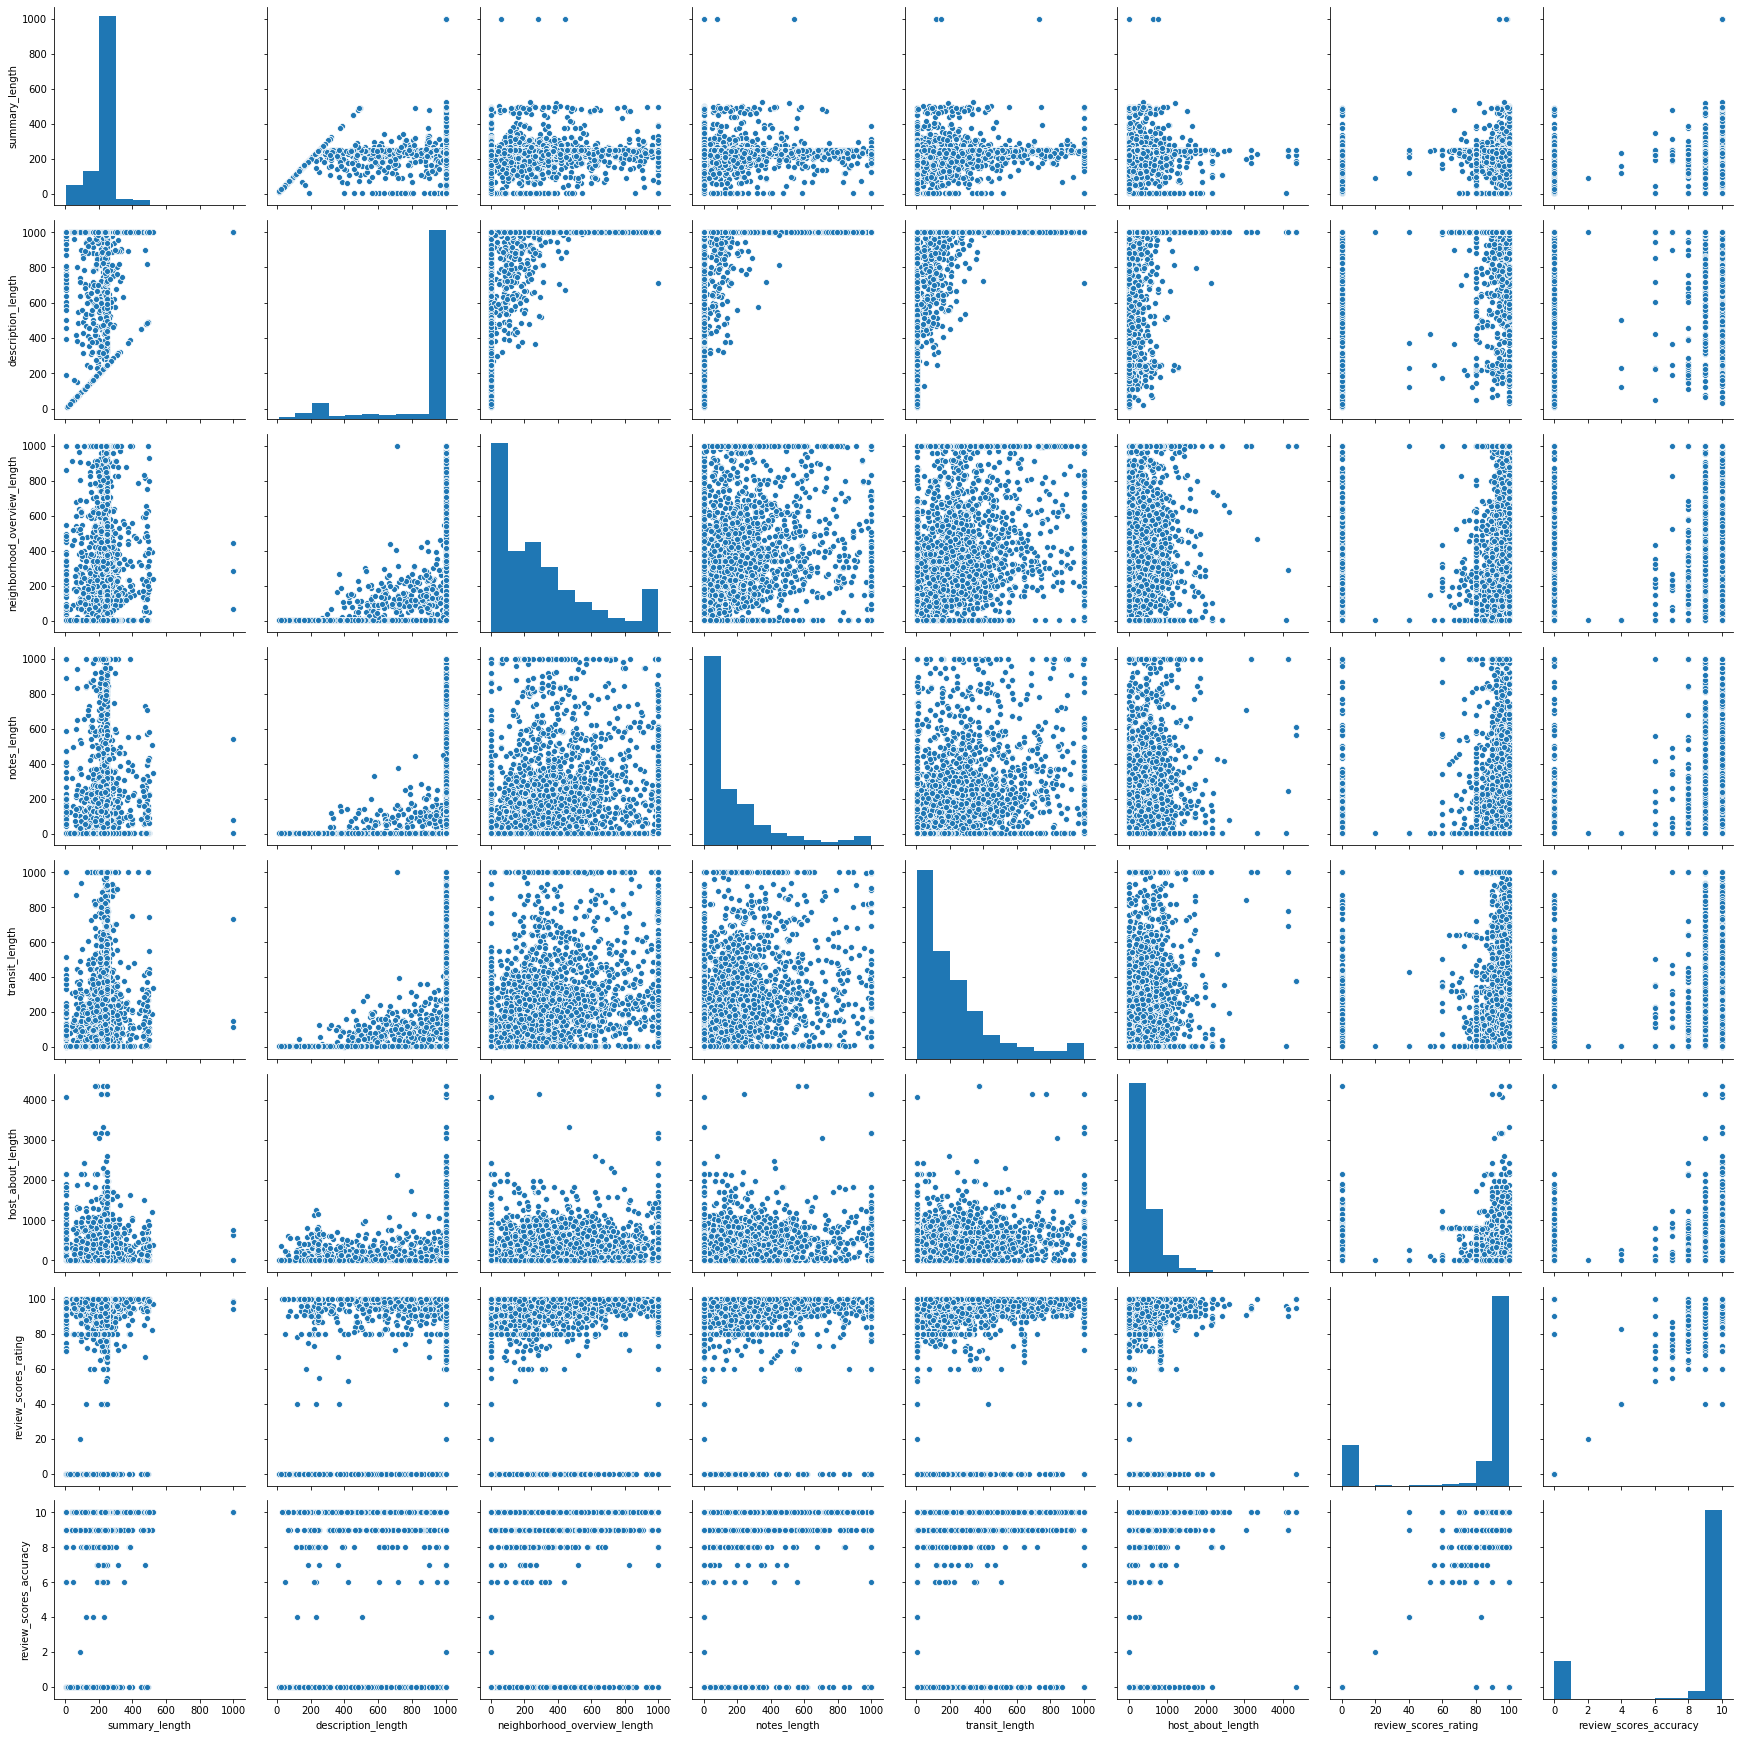

In [90]:
cols = ['summary_length',                          
'description_length',           
'neighborhood_overview_length',
'notes_length',
'transit_length',
'host_about_length',
'review_scores_rating',
'review_scores_accuracy']
sns.pairplot(cleaned[cols],size=3)
plt.show()

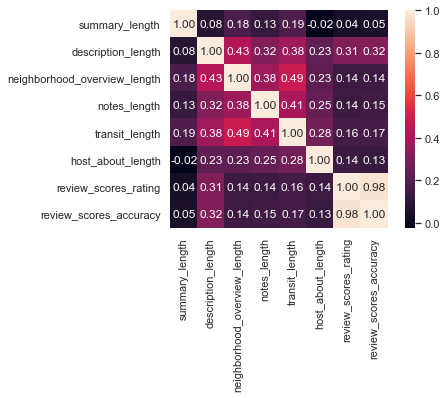

In [91]:
corrs = np.corrcoef(cleaned[cols].values.T)
sns.set(font_scale=1)
hm=sns.heatmap(corrs, cbar = True, annot=True, square = True, fmt = '.2f',
              yticklabels = cols, xticklabels = cols)

Text(0.5, 0, 'Listing price in $')

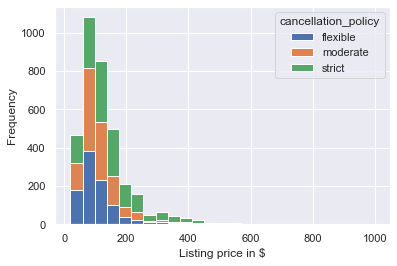

In [100]:
cleaned.pivot(columns = 'cancellation_policy',values = 'price').plot.hist(stacked = True,bins=25)
plt.xlabel('Listing price in $')

#### Impact of the property itself

In [101]:
cols = ['accommodates', 'bathrooms','bedrooms','beds','price']

/Users/philippmarcus/udacity/dsnd/01_writing_a_blog_post/condaenv/lib/python3.7/site-packages/seaborn/axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


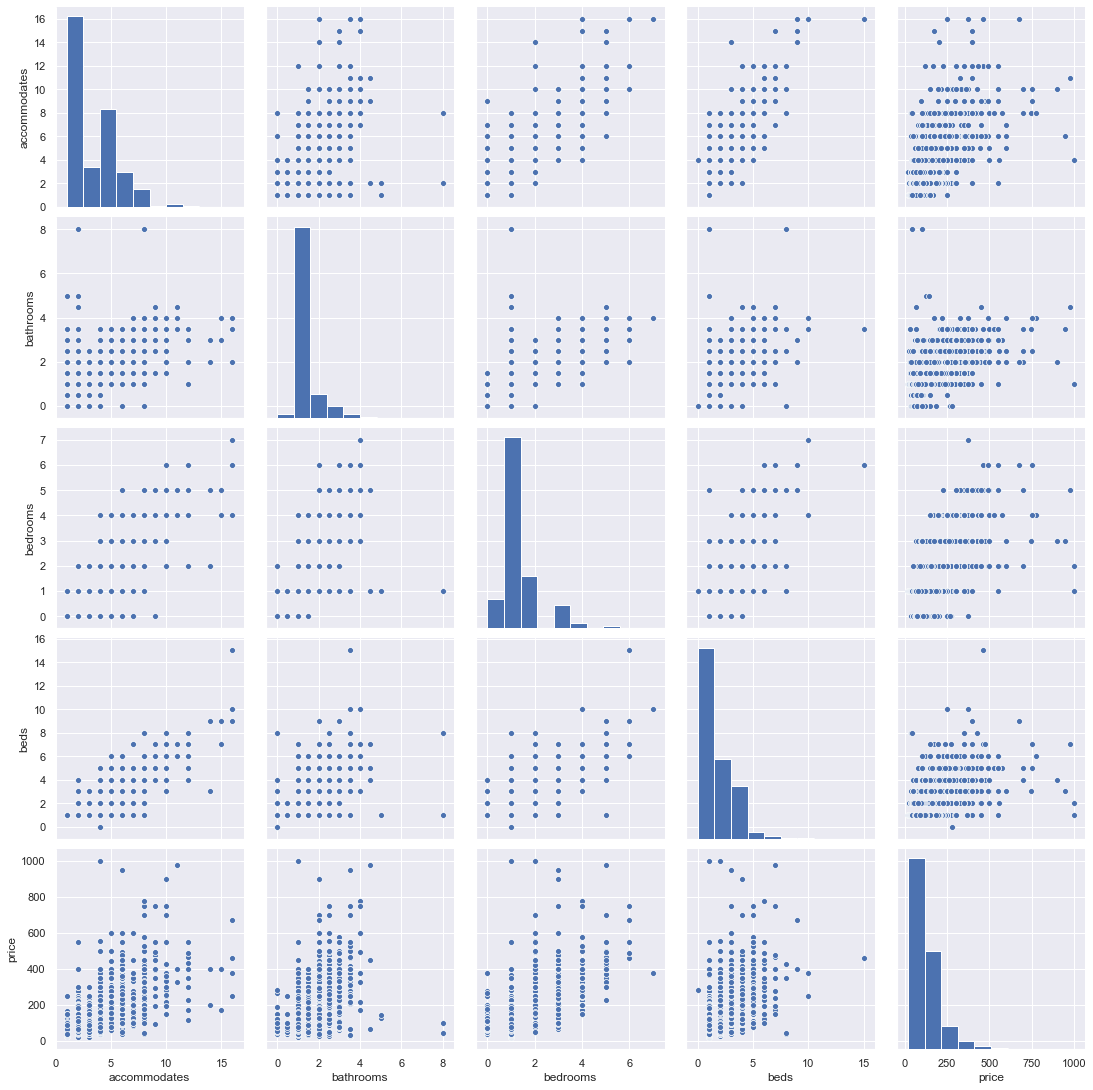

In [102]:
sns.pairplot(cleaned[cols],size=3)
plt.show()

#### **Question 1:** Which property type has the highest booking rates?

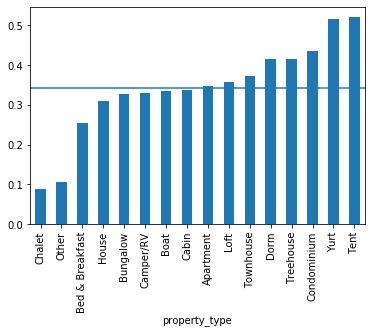

In [313]:
booking_rates_per_type = cleaned.groupby(['property_type'])['booking_rate'].mean().sort_values()
average = booking_rates_per_type.mean()
ax = booking_rates_per_type.plot.bar(x='property_type', y='booking_rate')
ax.axhline(average)
plt.show()

##### Average booking rate based on district?

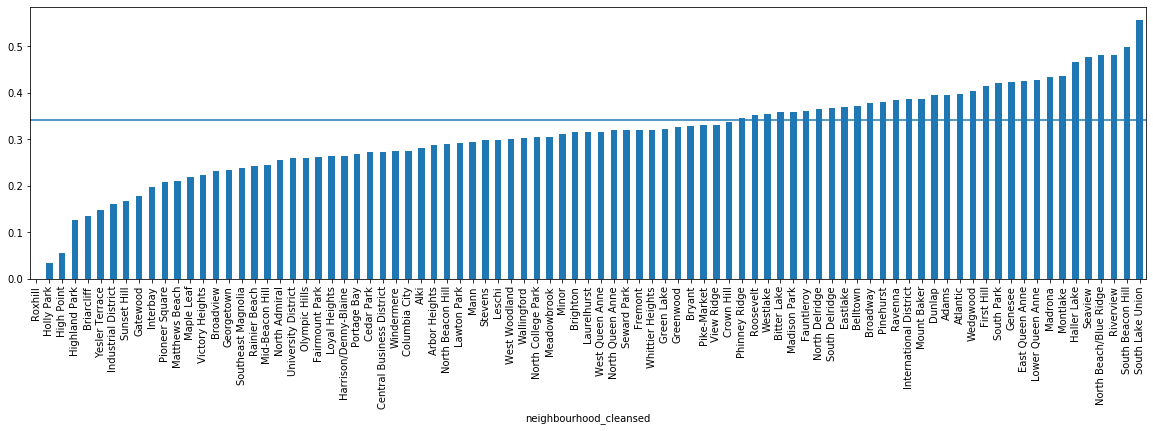

In [314]:
booking_rates_per_neighborhood = cleaned.groupby(['neighbourhood_cleansed'])['booking_rate'].mean().sort_values()
average = booking_rates_per_type.mean()
plt.figure(figsize=(20,5))
ax = booking_rates_per_neighborhood.plot.bar(x='neighbourhood', y='booking_rate')
ax.axhline(average)
plt.show()

***Average price per property type***

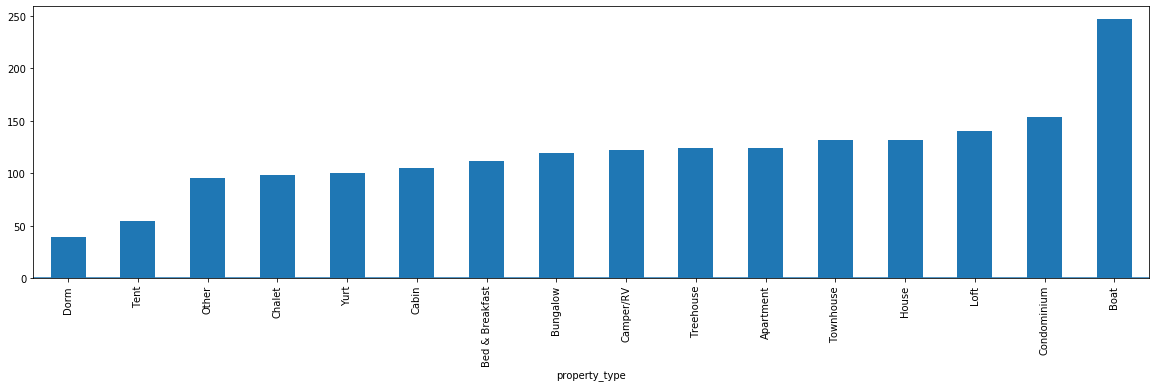

In [317]:
booking_rates_per_neighborhood = cleaned.groupby(['property_type'])['price'].mean().sort_values()
average = booking_rates_per_type.mean()
plt.figure(figsize=(20,5))
ax = booking_rates_per_neighborhood.plot.bar(x='property_type', y='price')
ax.axhline(average)
plt.show()

***Predominant property_type per neighbourhood***

In [321]:
val = cleaned.groupby(['neighbourhood_cleansed'])['property_type'].agg(pd.Series.mode)
val

neighbourhood_cleansed
Adams                                     House
Alki                                      House
Arbor Heights                             House
Atlantic                                  House
Belltown                              Apartment
Bitter Lake                               House
Briarcliff                                House
Brighton                                  House
Broadview                                 House
Broadway                              Apartment
Bryant                                    House
Cedar Park                                House
Central Business District             Apartment
Columbia City                             House
Crown Hill                                House
Dunlap                                    House
East Queen Anne                       Apartment
Eastlake                              Apartment
Fairmount Park                            House
Fauntleroy                                House
First Hill       

***Ranking of amenities per property type***

In [103]:
val = cleaned.groupby(['property_type'])

***Influence of competitors***


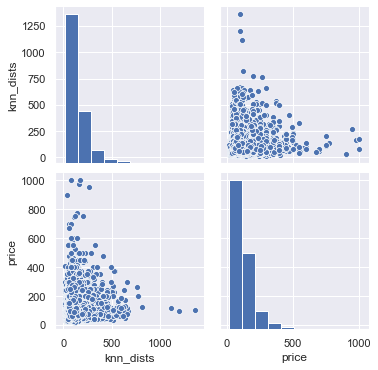

In [246]:
sns.pairplot(cleaned[['knn_dists','price']])

#### **Question 2:** Does the popularity of neighborhoods vary over the year?

In [ ]:
# booking rate for each neighborhood for each month. Show in a heatmap
# columns are the months, rows are each neighborhood


#### **Question 3:** Predict the booking rate based on the other factors.

In [173]:
(cleaned.isnull().sum() / len(cleaned)).sort_values()

id                                                                                   0.0
neighbourhood_cleansed_Sunset Hill                                                   0.0
neighbourhood_cleansed_University District                                           0.0
neighbourhood_cleansed_Victory Heights                                               0.0
neighbourhood_cleansed_View Ridge                                                    0.0
neighbourhood_cleansed_Wallingford                                                   0.0
neighbourhood_cleansed_Wedgwood                                                      0.0
neighbourhood_cleansed_West Queen Anne                                               0.0
neighbourhood_cleansed_West Woodland                                                 0.0
neighbourhood_cleansed_Westlake                                                      0.0
neighbourhood_cleansed_Whittier Heights                                              0.0
neighbourhood_cleanse

## 4. Data Modeling

In [331]:
#Labelize categorical columns or drop them

In [223]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([('scaler', StandardScaler()),\
                 ('model', RandomForestClassifier(n_estimators=20))])                      

In [224]:
txt_columns = list(cleaned.select_dtypes('object').keys())

y = cleaned['price']# * cleaned['booking_rate']
X = cleaned.drop(columns=['price', 'booking_rate','id', 'weekly_price', 'monthly_price']).drop(columns=txt_columns)
X.shape

(3512, 230)

In [225]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [226]:
model = pipe.fit(X_train, y_train)

In [227]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [228]:
importances = list(model['model'].feature_importances_)
cols = list(X.columns)
results = pd.DataFrame(data={'col':cols, 'importance':importances})

In [229]:
results = results.sort_values(by='importance', ascending=False)
results

col  importance
7                                            longitude    0.028647
6                                             latitude    0.027194
46                                           knn_dists    0.026867
47                                                 age    0.024978
37                                      summary_length    0.024583
35                                   reviews_per_month    0.022682
22                                    availability_365    0.022123
23                                   number_of_reviews    0.021900
42                                      transit_length    0.021637
14                                        cleaning_fee    0.021456
44                                   host_about_length    0.021396
40                        neighborhood_overview_length    0.021142
45                                       street_length    0.020781
36                                         name_length    0.020356
38                                        space_length    0.018909
41                                        notes_length    0.018781
21                                     availability_90    0.018761
43                                    host_name_length    0.018360
19                                     availability_30    0.018007
20                                     availability_60    0.017562
24                                review_scores_rating    0.016396
13                                    security_deposit    0.014205
9                                         accommodates    0.013608
18                                      maximum_nights    0.013522
16                                        extra_people    0.013078
3                            host_total_listings_count    0.011422
17                                      minimum_nights    0.011421
15                                     guests_included    0.011158
34                      calculated_host_listings_count    0.010477
39                                  description_length    0.009942
11                                            bedrooms    0.009754
0                                   host_response_rate    0.009470
10                                           bathrooms    0.008966
30                                 review_scores_value    0.008789
26                           review_scores_cleanliness    0.008620
12                                                beds    0.008093
206                 amenities_Free Parking on Premises    0.007648
25                              review_scores_accuracy    0.007372
29                              review_scores_location    0.007289
205                            amenities_First Aid Kit    0.006725
228  host_verifications_host_verifications_host_ver...    0.006671
179                      amenities_Family/Kid Friendly    0.006468
27                               review_scores_checkin    0.006436
197                                 amenities_Cable TV    0.006270
213                        amenities_amenities_Shampoo    0.006268
224  host_verifications_host_verifications_host_ver...    0.006199
214                                           facebook    0.006192
177                                       amenities_TV    0.006172
182                        amenities_Fire Extinguisher    0.005992
170                  host_response_time_within an hour    0.005983
180                 amenities_Carbon Monoxide Detector    0.005947
48                             property_type_Apartment    0.005935
184                                 amenities_Internet    0.005927
219                                           linkedin    0.005822
154                       cancellation_policy_moderate    0.005779
193                         amenities_Indoor Fireplace    0.005688
223  host_verifications_host_verifications_host_ver...    0.005533
188                                   amenities_Washer    0.005460
163                          room_type_Entire home/apt    0.005301
207                            

In [233]:
top_cols = list(results['col'])[0:5] + ['price', 'booking_rate']

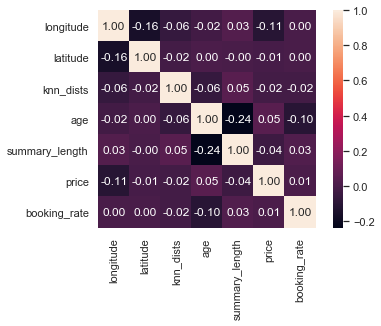

In [234]:
corrs = np.corrcoef(cleaned[top_cols].values.T)
sns.set(font_scale=1)
hm=sns.heatmap(corrs, cbar = True, annot=True, square = True, fmt = '.2f',
              yticklabels = top_cols, xticklabels = top_cols)

In [145]:
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

In [113]:
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 0.000, test: 1866.803
R^2 train: 1.000, test: 0.724


## 5. Evaluation